In [2]:
from datasets import *
from transformers import ViTFeatureExtractor, ViTImageProcessor
from transformers import ViTModel

from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np
import pandas as pd 
import torch.nn as nn
import pickle
from matplotlib import pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix

# import wandb
# wandb.login(key='c95512bbacaf395b474551d0769bbb8f7c580f5d', force=True)

string_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

fer_df = pd.read_csv("fer2013/fer2013.csv")  # available on kaggle
def prepare_fer_data(data):
    """ Prepare fer data for vision transformer 
        input: fer df loaded from csv
        output: df that can be load into a huggingface dataset """

    # outputs
    image_list = []
    image_labels = list(map(int, data['emotion']))
    
    # go over all images
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        # adapt grayscale to rgb format (change single values to triplets of the same value)
        image = image[..., np.newaxis]
        image = np.repeat(image, 3, axis=2)
        # convert to list format used by the later functions
        image = image.astype(int).tolist()
        # save to output
        image_list.append(image)

    output_df = pd.DataFrame(list(zip(image_list, image_labels)),
               columns =['img', 'label'])
        
    return output_df

def preprocess_images(examples):
    """ Prepare datasets for vision transformer 
    input: dataset with images in their orignal size 
    output: dataset with pixelvalues computed by the feature extractor added """
    # get batch of images
    images = examples['img']
    # convert to list of NumPy arrays of shape (C, H, W)
    images = [np.array(image, dtype=np.uint8) for image in images]
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    # preprocess and add pixel_values
    inputs = feature_extractor(images=images)
    examples['pixel_values'] = inputs['pixel_values']

    return examples

fer_test_df = prepare_fer_data(fer_df[fer_df['Usage']=='PrivateTest'])
test_ds = Dataset.from_pandas(fer_test_df[0:10])
features = Features({
    'label': ClassLabel(names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']),
    'img': Array3D(dtype="int64", shape=(3,48,48)),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

preprocessed_test_ds = test_ds.map(preprocess_images, batched=True, batch_size=1, features=features)

from transformers.modeling_outputs import ImageClassifierOutput
from transformers import ViTConfig, ViTPreTrainedModel
class ViTForImageClassification2(ViTPreTrainedModel):
    #define architecture
    def __init__(self, config: ViTConfig, num_labels=len(string_labels)):
        super().__init__(config)
        self.vit = ViTModel(config, add_pooling_layer=False)
        self.config = config
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        self.num_labels = num_labels

    #define a forward pass through that architecture + loss computation
    def forward(self, pixel_values, labels=None):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return ImageClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )



Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [ ]:
import torch
a = torch.nn(1, 1)

In [3]:
metric_name = "accuracy"

model = ViTForImageClassification2.from_pretrained('./hello')   
    

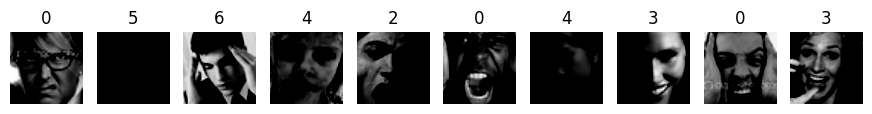

In [4]:
# show 100 images from the dataset
fig, axes = plt.subplots(1,10, figsize=(11,11))
for i,ax in enumerate(axes.flat):
  data_for_image = np.array(preprocessed_test_ds[i]["pixel_values"])
  data_for_image[data_for_image < 0] = 0 
  ax.imshow(np.transpose(data_for_image, (1,2,0)), interpolation='nearest')
  ax.set_title(preprocessed_test_ds[i]["label"])
  ax.set_axis_off()

In [5]:
import evaluate
from transformers import TrainingArguments, Trainer
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

trainer2 = Trainer(
    model = model,
    compute_metrics = compute_metrics
    
)
ground_truth = trainer2.predict(preprocessed_test_ds)
real_output2 = ground_truth.predictions.argmax(1)
ground_truth.label_ids, real_output2

  0%|          | 0/2 [00:00<?, ?it/s]

(array([0, 5, 6, 4, 2, 0, 4, 3, 0, 3], dtype=int64),
 array([3, 3, 6, 6, 0, 0, 6, 6, 3, 4], dtype=int64))

In [6]:
ground_truth.label_ids[0]

0

In [7]:
ground_truth.metrics

{'test_loss': 1.8911653757095337,
 'test_accuracy': 0.2,
 'test_runtime': 1.6164,
 'test_samples_per_second': 6.186,
 'test_steps_per_second': 1.237}

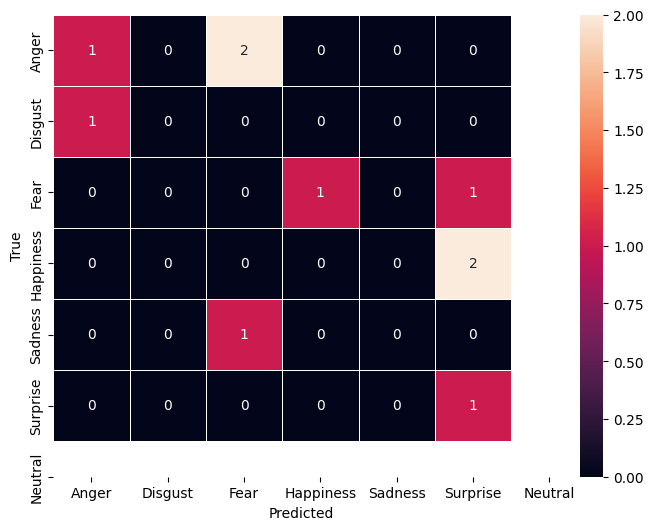

In [8]:
y_true = ground_truth.label_ids
y_pred = ground_truth.predictions.argmax(1)

cm = confusion_matrix(y_true, y_pred)

# plot with seaborn
fig, ax = plt.subplots(figsize=(8,6))  
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, xticklabels=string_labels, yticklabels=string_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [9]:
from PIL import Image, ImageOps
import cv2
image2 = cv2.imread('14.jpg')
gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

In [10]:
# img = cv2.imread('14_gray.jpg')
img.shape


(388, 388, 3)

Text(0.5, 1.0, 'Happiness')

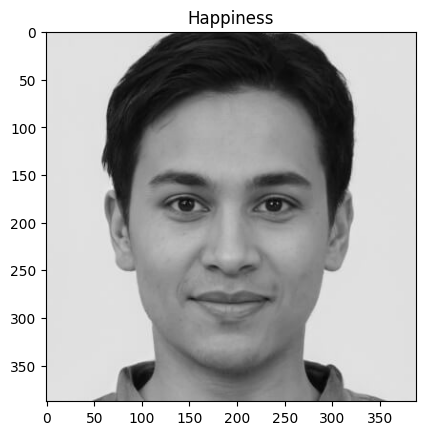

In [11]:
import torch 

# image2 = Image.open('14.jpg').convert('L')
inputs = feature_extractor(img, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
plt.imshow(img)
plt.title(string_labels[predicted_label])

In [12]:

probs = torch.softmax(logits, dim=-1)
probs, logits, probs.max()

(tensor([[0.1455, 0.1152, 0.1410, 0.1710, 0.1627, 0.1095, 0.1551]]),
 tensor([[ 0.0387, -0.1949,  0.0077,  0.2001,  0.1506, -0.2453,  0.1026]]),
 tensor(0.1710))

In [17]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)

from torchvision import transforms
# transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
# def load_img(path):
#     img = Image.open(path)
#     img = transformation(img).float()
#     img = torch.autograd.Variable(img,requires_grad = True)
#     img = img.unsqueeze(0)
#     return img.to('cpu')

while True:
        # Read the frame
        _, img = cap.read()
        # Convert to grayscale
        img = cv2.flip(img, 1)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Detect the faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        # Draw the rectangle around each face
        for (x, y, w, h) in faces:
            roi = img[y:y+h, x:x+w]
            roi = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
            roi = cv2.cvtColor(roi,cv2.COLOR_GRAY2BGR)
            #cv2.imwrite("roi.jpg", roi)
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        #roi = load_img("roi.jpg")
        imgg = feature_extractor(roi, return_tensors='pt')
        with torch.no_grad():
            logits = model(**imgg).logits


        predicted_label = logits.argmax(-1).item()
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        org = (50, 50)
        fontScale = 1
        color = (255, 0, 0)
        thickness = 2
        prob = torch.softmax(logits, dim=-1).max(dim=-1)[0].item()
        final_img = cv2.putText(img, f'{string_labels[predicted_label]} {prob:.2f}', org, font,
                       fontScale, color, thickness, cv2.LINE_AA)

        cv2.imshow('img', final_img)
        # Stop if (Q) key is pressed
        k = cv2.waitKey(30)
        if k==ord("q"):
            break

    # Release the VideoCapture object
cap.release()


KeyboardInterrupt: 

: 